# ANTsPy First usages

In [1]:
import ants
import pyvista as pv
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import napari
from vtk import vtkImageData
import SimpleITK as sitk
import scipy.ndimage as ndimage
from skimage.feature import blob_dog, blob_log, blob_doh


from helpers import explore_3D_array
from helpers import explore_3D_array_comparison
from skimage import feature
from helpers import explore_3D_blobs



## Loading simple files 

### .nrrd files

In [2]:
# Load image
img = ants.image_read("Data/8.31-D0-FAT.nrrd")

# Check info
print(img)
print(img.shape)

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (333, 333, 40)
	 Spacing    : (0.2102, 0.2102, 1.25)
	 Origin     : (-40.8031, -35.9861, -25.935)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

(333, 333, 40)


### .tsv files

In [3]:
df = pd.read_csv("Data/Table_1.schema.tsv", sep="\t")
df.head()

,columnName,title,Plugin,description,unitLabel,DICOM.QuantityCode,DICOM.UnitsCode,type,componentNames
0,Segment,Segment,NaN,NaN,NaN,NaN,NaN,string,NaN
1,Voxel count,Voxel count,Label Map,Number of voxels in the binary labelmap repres...,NaN,CodeValue:nvoxels|CodingSchemeDesignator:99QII...,CodeValue:voxels|CodingSchemeDesignator:UCUM|C...,long,NaN
2,Volume mm3,Volume,Label Map,Volume of the segment computed from binary lab...,mm3,CodeValue:118565006|CodingSchemeDesignator:SCT...,CodeValue:mm3|CodingSchemeDesignator:UCUM|Code...,double,NaN
3,Surface mm2,Surface area,Label Map,Surface area of the segment computed from bina...,mm2,CodeValue:000247|CodingSchemeDesignator:99CHEM...,CodeValue:mm2|CodingSchemeDesignator:UCUM|Code...,double,NaN
4,Roundness,Roundness,Label Map,Segment roundness. Calculated from ratio of th...,NaN,NaN,NaN,double,NaN


### .mrml files

.mrml files cannot be directly loaded as objects within pythons, rather all of the correponding scans and segmentations must be loaded in seperately.

## Visualizations 

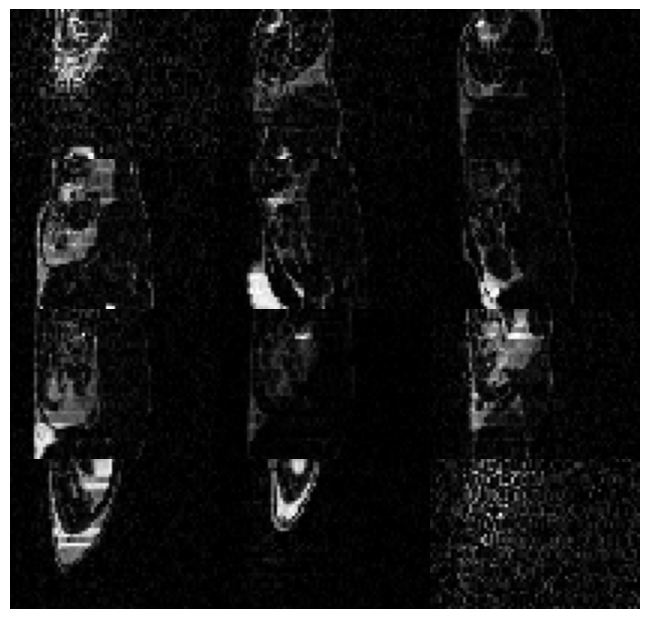

In [4]:
img = ants.image_read("Data/8.31-D0-FAT.nrrd")
ants.plot (img)

In [5]:
mask = ants.get_mask(img)
mask_aa = ants.anti_alias(mask)

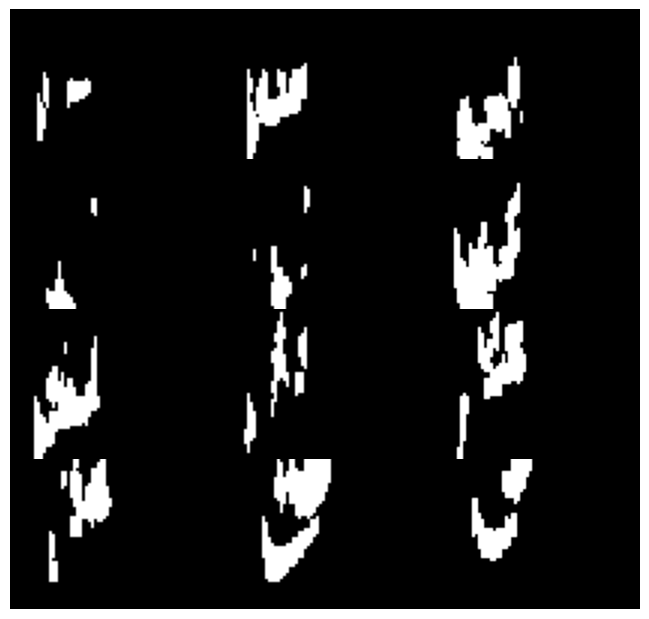

In [11]:
ants.plot(mask)

In [17]:
ants.plot(mask_aa)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [18]:
print(mask_aa.shape)
print(mask_aa.min(), mask_aa.max())
print(mask_aa.sum())


(333, 333, 40)
-4.0 4.0
-16201572.0


In [21]:
print(mask.shape)
print(mask.min(), mask.max())
print(mask.sum())


(333, 333, 40)
0.0 1.0
188385.0


## Registration 

### Transofrmation between two images 

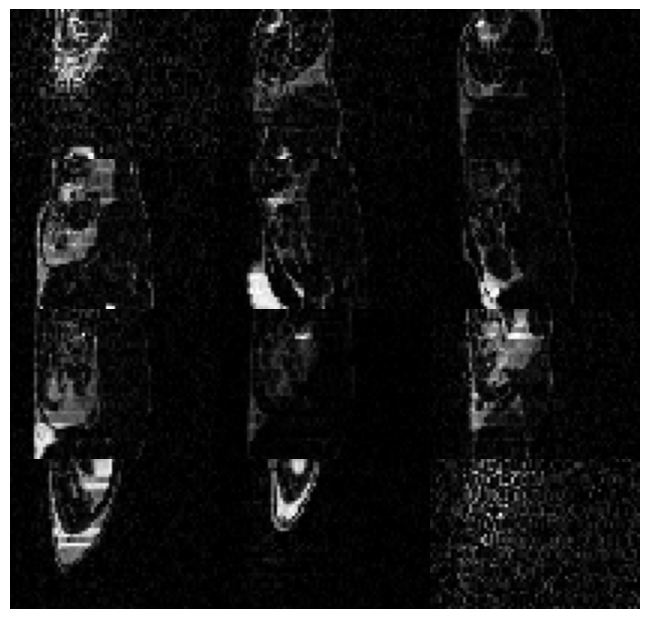

In [24]:
img1 = ants.image_read("Data/8.31-D0-FAT.nrrd")
img2 = ants.image_read("Data/8.31-D1-FAT.nrrd")

ants.plot(img1)

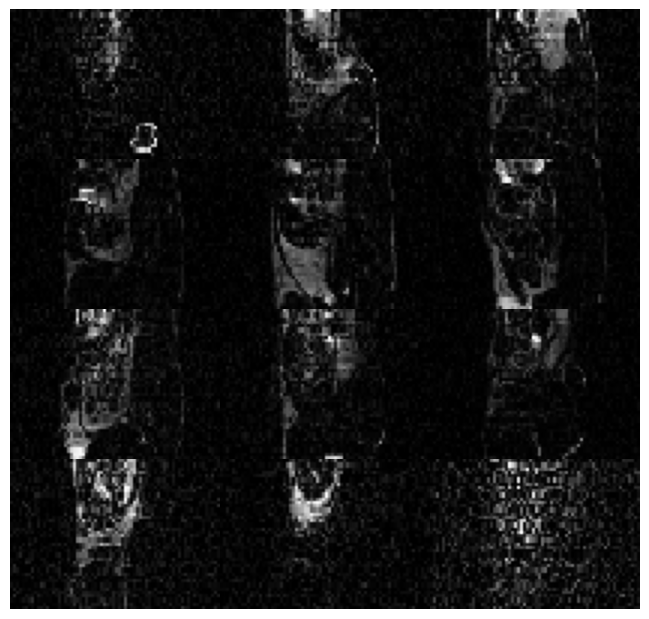

In [25]:
ants.plot(img2)

In [28]:
transformation = ants.registration(
    fixed=img1, # Template/reference image
    moving=img2, # Img that will be "transformed"
    type_of_transform='SyN', # Default Value
    verbose=True
)

antsRegistration --dimensionality 3 -r [00000274BDE560A8,00000274BDE56468,1] --metric mattes[00000274BDE560A8,00000274BDE56468,1,32,regular,0.2] --transform Affine[0.25] --convergence 2100x1200x1200x0 --smoothing-sigmas 3x2x1x0 --shrink-factors 4x2x2x1 -x [NA,NA] --metric mattes[00000274BDE560A8,00000274BDE56468,1,32] --transform SyN[0.200000,3.000000,0.000000] --convergence [40x20x0,1e-7,8] --smoothing-sigmas 2x1x0 --shrink-factors 4x2x1 -u 0 -z 1 --output [C:\Users\alyel\AppData\Local\Temp\tmpkzc4ia51,00000274BDE56768,00000274BDE56148] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1


In [29]:
transformation

{'warpedmovout': ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (333, 333, 40)
 	 Spacing    : (0.2102, 0.2102, 1.25)
 	 Origin     : (-40.8031, -35.9861, -25.935)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
 'warpedfixout': ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (333, 333, 40)
 	 Spacing    : (0.2102, 0.2102, 1.25)
 	 Origin     : (-36.1905, -42.0833, -24.375)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\alyel\\AppData\\Local\\Temp\\tmpkzc4ia511Warp.nii.gz',
  'C:\\Users\\alyel\\AppData\\Local\\Temp\\tmpkzc4ia510GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\alyel\\AppData\\Local\\Temp\\tmpkzc4ia510GenericAffine.mat',
  'C:\\Users\\alyel\\AppData\\Local\\Temp\\tmpkzc4ia511InverseWarp.nii.gz']}

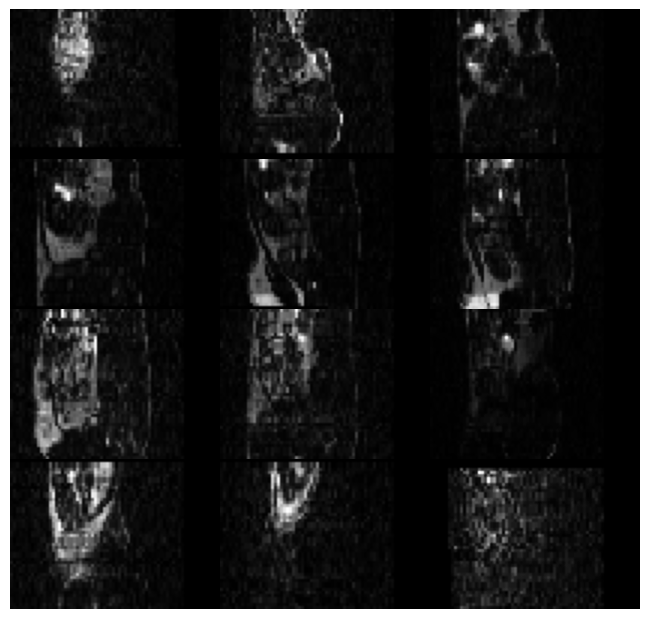

In [31]:
# Retreiving transformed image

transformation['warpedmovout']
ants.plot(transformation['warpedmovout'])

In [56]:
def plot_side_by_side(img1, img2, slice_idx=None, cmap="gray"):
    if slice_idx is None:
        slice_idx = img1.shape[2] // 2

    # Save temporary slices as images using ants.plot
    ants.plot(img1, slices=[slice_idx], cmap=cmap, filename="tmp1.png")
    ants.plot(img2, slices=[slice_idx], cmap=cmap, filename="tmp2.png")

    # Load saved images with Matplotlib
    im1 = mpimg.imread("tmp1.png")
    im2 = mpimg.imread("tmp2.png")

    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(im1)
    axes[0].axis("off")
    axes[0].set_title("Image 1")
    axes[1].imshow(im2)
    axes[1].axis("off")
    axes[1].set_title("Image 2")
    plt.tight_layout()
    plt.show()

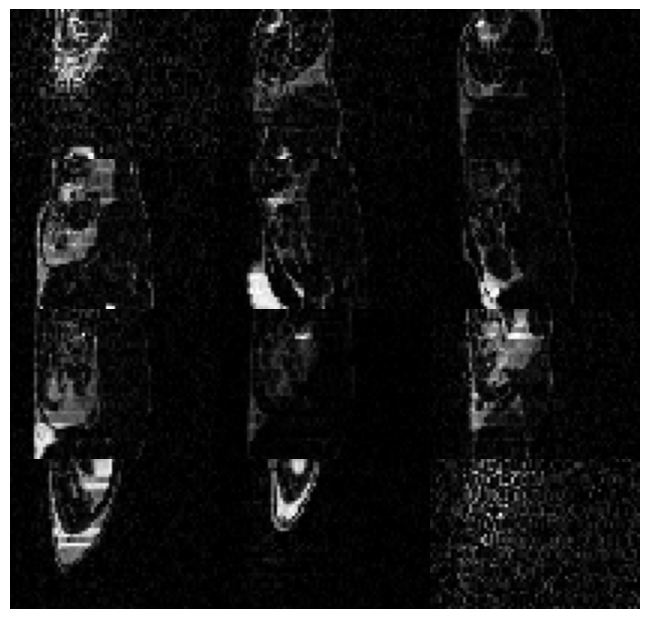

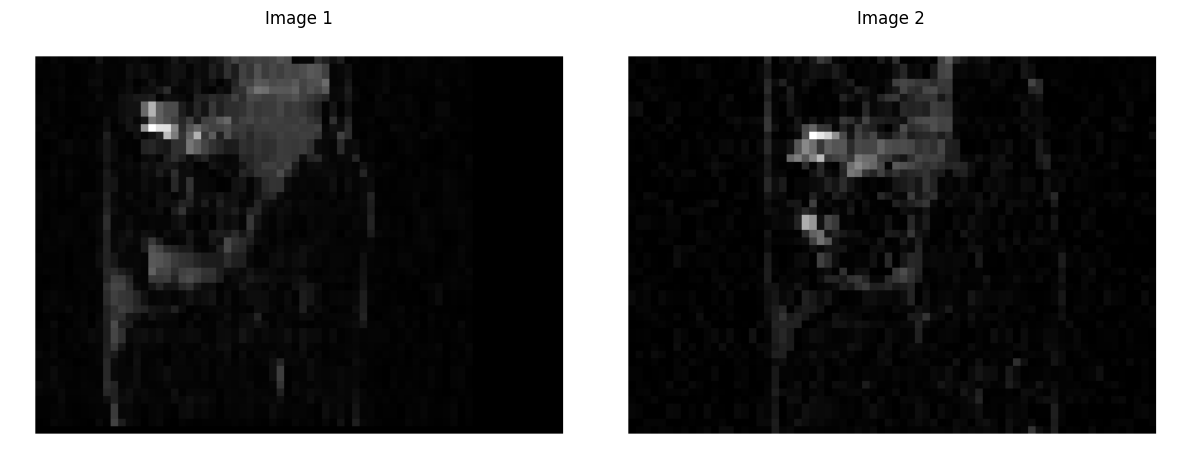

In [57]:
ants.plot(img1)
plot_side_by_side(transformation['warpedmovout'], img2)

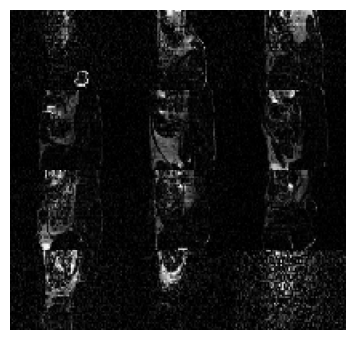

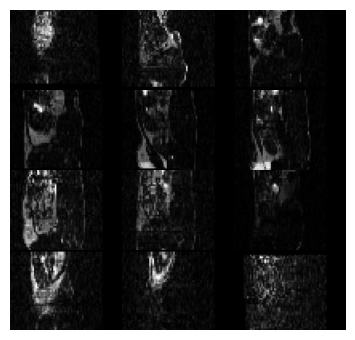

(None, None)

In [67]:
ants.plot(img2, figsize=0.8), ants.plot(transformation['warpedmovout'], figsize=0.8)

In [71]:
print(img1)

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (333, 333, 40)
	 Spacing    : (0.2102, 0.2102, 1.25)
	 Origin     : (-40.8031, -35.9861, -25.935)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]



## Loading all Images 

In [75]:
def create_nrrd_dataframe_with_ants(folder_path):
    """
    Scans a folder for .nrrd files, creates a DataFrame with columns:
    'File', 'Rat', 'Week', 'Scan Type', and loads each as an ants image.
    
    Args:
        folder_path (str): Path to the folder containing .nrrd files.
    
    Returns:
        pd.DataFrame
    """
    records = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".nrrd"):
            parts = filename.split('-')
            if len(parts) >= 3:
                rat = parts[0]
                week = parts[1]
                scan_type = parts[2].replace(".nrrd", "")
                
                # full path to the file
                file_path = os.path.join(folder_path, filename)
                
                # load as ants image
                ants_img = ants.image_read(file_path)
                
                records.append({
                    "File": filename,
                    "Rat": rat,
                    "Week": week,
                    "Scan Type": scan_type,
                    "ANTsImage": ants_img
                })
    
    df = pd.DataFrame(records)
    return df

In [77]:
folder = r"Data"
df_nrrd = create_nrrd_dataframe_with_ants(folder)

In [87]:
df_nrrd.head()
df_nrrd.shape

(76, 5)

In [88]:
first_file = df_nrrd.iloc[0]

In [89]:
first_file

File                                          8.31-D0-FAT.nrrd
Rat                                                       8.31
Week                                                        D0
Scan Type                                                  FAT
ANTsImage    ANTsImage (RAI)\n\t Pixel Type : float (float3...
Name: 0, dtype: object

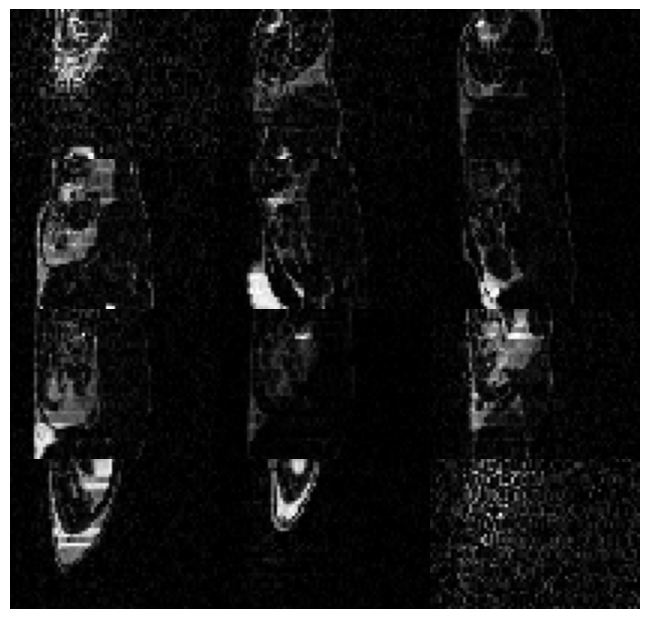

In [90]:
ants.plot(first_file['ANTsImage'])

## Identifying the different "BLOBS"

### k-means clustering

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (333, 333, 40)
	 Spacing    : (0.2102, 0.2102, 1.5)
	 Origin     : (-40.8031, -35.9861, -24.25)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

(333, 333, 40)


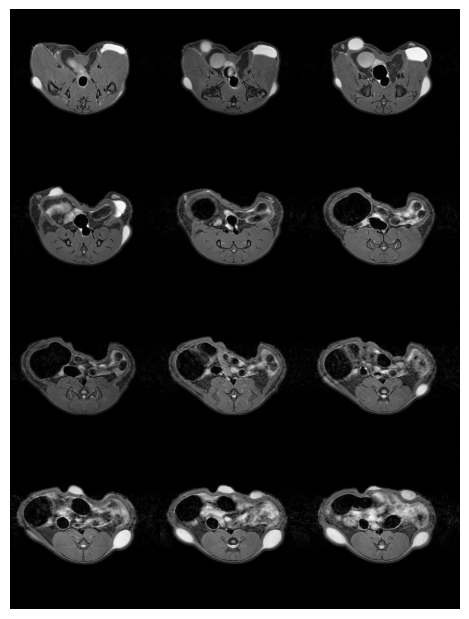

In [2]:
# Load image
path = "Data/8.33-D2-WATER.nrrd"
img = ants.image_read(path)
img_sitk = sitk.ReadImage(path)

# Check info
print(img)
print(img.shape)
ants.plot(img, axis = 2)

In [3]:
explore_3D_array(img.numpy())

interactive(children=(IntSlider(value=19, description='SLICE', max=39), Output()), _dom_classes=('widget-inter…

In [4]:
print("Origin:", img.origin)        # voxel (0,0,0) physical location in world coords
print("Spacing:", img.spacing)      # voxel size along each axis
print("Direction:", img.direction)  # 3x3 direction cosine matrix
print("Dimension:", img.dimension)  # 3 for 3D
print("Size:", img.shape)           # number of voxels per axis


Origin: (-40.80307388305665, -35.98614501953125, -24.250000000000004)
Spacing: (0.21021020412445068, 0.21021020412445068, 1.5)
Direction: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Dimension: 3
Size: (333, 333, 40)


### Thresholding for blobs differentiation

#### OtsuThresholding

In [5]:
# Set Origin to corner (0,0,0)
img.set_origin([0, 0, 0])
img.origin

(0.0, 0.0, 0.0)

In [6]:
mask_otsu = sitk.OtsuMultipleThresholds(img_sitk)

# Cast to float BEFORE sending to antspy
mask_otsu = sitk.Cast(mask_otsu, sitk.sitkFloat32)

# Now convert
mask_otsu = ants.from_sitk(mask_otsu)

In [ ]:
explore_3D_array_comparison(
    arr_before=img.numpy(),
    arr_after=mask_otsu.numpy()
)

interactive(children=(IntSlider(value=19, description='SLICE', max=39), Output()), _dom_classes=('widget-inter…

Different preprocessing methods need to be applied on the mask in order to have "identifiable" blobs, so we first must apply these different preprocessing techniques.

### Morphological operations : Dilation and Closure

#### Dilation

For an antsPy image 

In [8]:
radius = 1.
mask_dilat = ants.morphology(
    image=mask_otsu,
    operation="dilate",
    mtype="binary",
    radius=radius
)

# mask_dilat = ants.iMath(mask_otsu, "MD", radius)

explore_3D_array_comparison(
    arr_before=mask_otsu.numpy(),
    arr_after=mask_dilat.numpy()
)

interactive(children=(IntSlider(value=19, description='SLICE', max=39), Output()), _dom_classes=('widget-inter…

#### Closure 

For an antsPy image

In [9]:
mask_dilat_closed = ants.morphology(mask_dilat, radius=1.2, operation="close", mtype = "grayscale")

explore_3D_array_comparison(
    arr_before=mask_dilat.numpy(),
    arr_after=mask_dilat_closed.numpy()
)

interactive(children=(IntSlider(value=19, description='SLICE', max=39), Output()), _dom_classes=('widget-inter…

### Blob Centroids

Two alogrithms are used to identify the blob centroids, Laplacian of Gaussian (LoG) and Difference of Gaussian (DoG), in order to identify which method finds the better centorids.

In [10]:
# --- Blob detection with Laplacian of Gaussian (LoG) ---
mask_dilat_closed.set_origin((0,0,0))
mask_numpy = mask_dilat_closed.numpy()

blobs_log = blob_log(
    mask_numpy,
    min_sigma=1,       # smallest std dev of Gaussian kernel
    max_sigma=10,      # largest std dev
    num_sigma=10,      # number of intermediate scales
    threshold=0.05,    # lower = more blobs detected
    overlap=0.5
)

# The radii of the blobs can be approximated as sqrt(2) * sigma
blobs_log[:, -1] = blobs_log[:, -1] * np.sqrt(2)

# Sort based on raidus (descending)
blobs_log = blobs_log[np.argsort(blobs_log[:, 3])[::-1]]

# --- Difference of Gaussian (DoG) ---
blobs_dog = blob_dog(
    mask_numpy,
    min_sigma=1,
    max_sigma=10,
    sigma_ratio=1.6,
    threshold=0.05,
    overlap=0.5
)
blobs_dog[:, -1] = blobs_dog[:, -1] * np.sqrt(2)

# Sort based on raidus (descending)
blobs_dog = blobs_dog[np.argsort(blobs_dog[:, 3])[::-1]]

# Print results
print("LOG blobs found:", blobs_log.shape[0])
print("DOG blobs found:", blobs_dog.shape[0])

# Each row in blobs_* is: (z, y, x, radius)
print("First few LOG blobs:\n", blobs_log[:5])
print("First few DOG blobs:\n", blobs_dog[:5])

LOG blobs found: 1908
DOG blobs found: 1674
First few LOG blobs:
 [[ 95.        85.        18.        14.142136]
 [178.        72.        39.        14.142136]
 [304.       129.        34.        14.142136]
 [278.       120.         0.        14.142136]
 [231.        96.         0.        14.142136]]
First few DOG blobs:
 [[ 77.       169.        14.         9.268189]
 [282.       122.         0.         9.268189]
 [227.        94.         0.         9.268189]
 [256.        75.        21.         9.268189]
 [273.       156.         2.         9.268189]]


#### Visulaization for LOG Blobs

In [11]:
explore_3D_blobs(mask_numpy, blobs=blobs_log)

Blob coordinates and radii (x, y, z, r):
[[ 95.         85.         18.         14.142136 ]
 [178.         72.         39.         14.142136 ]
 [304.        129.         34.         14.142136 ]
 ...
 [238.         86.         21.          1.4142135]
 [ 14.        143.         36.          1.4142135]
 [  5.        138.         36.          1.4142135]]


interactive(children=(IntSlider(value=19, description='slice_idx', max=39), Output()), _dom_classes=('widget-i…

#### Visulaization for DOG Blobs

In [ ]:
explore_3D_blobs(mask_numpy, blobs=blobs_dog)

Blob coordinates and radii (x, y, z, r):
[[ 77.        169.         14.          9.268189 ]
 [282.        122.          0.          9.268189 ]
 [227.         94.          0.          9.268189 ]
 ...
 [ 77.        199.         28.          1.4142135]
 [270.        192.         33.          1.4142135]
 [ 96.        161.         39.          1.4142135]]


interactive(children=(IntSlider(value=19, description='slice_idx', max=39), Output()), _dom_classes=('widget-i…